In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.polynomial.polynomial import Polynomial

# Load the data
dataframe = r"C:\Users\bongo\OneDrive\Desktop\Phenolic compound\Total phenolics.xlsx"
df = pd.read_excel(dataframe)

# Extract the X and y data
X = df.iloc[:, 2:].values  # Ensure it's a NumPy array
y = df.iloc[:, 1].values

# Apply Savitzky-Golay filter
X_filtered = savgol_filter(X, window_length=3, polyorder=2, axis=0)

# Continuum removal using polynomial fitting
def continuum_removal(data):
    continuum = np.zeros_like(data)
    for i in range(data.shape[1]):  # Loop through each spectral feature
        x = np.arange(data.shape[0])
        # Fit a polynomial of degree 3 (or adjust as necessary)
        p = Polynomial.fit(x, data[:, i], 3)
        continuum[:, i] = p(x)
    return data / continuum  # Divide original data by the continuum

# Perform continuum removal
X_continuum_removed = continuum_removal(X_filtered)

# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_continuum_removed, y, test_size=0.3, random_state=45)

# Train the Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor(n_estimators=100, random_state=45)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Calculate and print the evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Evaluation Metrics:
Mean Squared Error: 285.60
R-squared: 0.80


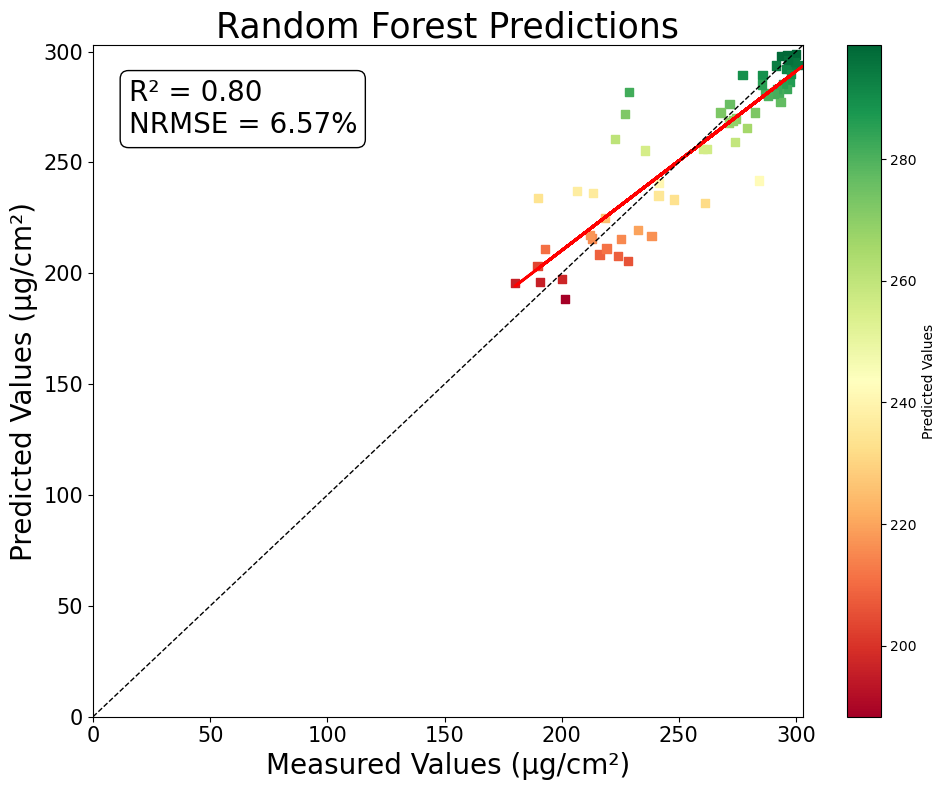

In [8]:
# Calculate NRMSE and fit a linear regression model for the regression line
nrmse = np.sqrt(mse) / np.mean(y_test) * 100  # NRMSE calculation
model = LinearRegression()
model.fit(y_test.reshape(-1, 1), y_pred)
a = model.coef_[0]
b = model.intercept_

# Create the scatter plot with graduated colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(y_test, y_pred, c=y_pred, cmap='RdYlGn', marker='s', label='Data Points')

# Plot the linear regression line
plt.plot(y_test, a * y_test + b, color='red', linestyle='-', linewidth=2, label='Regression Line')

# Add the 1:1 line
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1, label='1:1 Line')

# Add labels and title
plt.xlabel('Measured Values (μg/cm²)', fontsize=20)
plt.ylabel('Predicted Values (μg/cm²)', fontsize=20)
plt.title('Random Forest Predictions', fontsize=25)
plt.grid(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(scatter, label='Predicted Values')

# Add R² and NRMSE (%) information
text = f'R² = {r2:.2f}\nNRMSE = {nrmse:.2f}%'
plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, fontsize=20, verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.tight_layout()
plt.xlim(0, max_val)
plt.ylim(0, max_val)
#plt.legend()
plt.show()